In [80]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import numpy as np

# Tracking vidéo
En partant d'une première détection de l'objet d'intérêt qui prend la forme d'une boite englobante que l'on suppose correcte, on va suivre l'objet sur les frames suivantes.

Pour chaque frame, on prend la boîte englobante de la frame précédente, on va créer un set de nouvelles boîtes potentielles. On va ensuite récupérer le "patch" de l'image associé à chaque nouvelle boîte englobante et effectuer une prediction à l'aide du modèle précédemment créé. On conservera comme nouvelle boîte celle qui fournira la prédiction la plus précise (pourcentage le plus élevé).

In [179]:
def display_images(images, lab, n_line, l_col):
    """ Function used to display mutliple image with pyplot
    """
    plt.figure(figsize=(10, 10))
    for i in range(min(n_line*l_col, len(images))):
        ax = plt.subplot(n_line, l_col, i + 1)
        plt.imshow(images[i])
        plt.title(f'({lab[i]:.2})')
        plt.axis("off")

In [180]:
def build_boxes(x, y, w, h, N, stride):
    """ Build a set of new potential bouding boxes from a given box
    """
    # N = 15
    # stride = 1
    shift = list(range(-N, N+1, stride))
    zoom = [1.3, 1, 0.8]
    
    pos = []
    for i in shift:
        new_x = x + i
        
        for j in shift:
            new_y = y + j
            
            new_pos = (new_x, new_y, w, h)
            pos.append(new_pos)
            
            for z in zoom:
                new_w, new_h = int(w*z), int(h*z)
                new_x = new_x - (abs(new_w - w) // 2)
                new_y = new_y - (abs(new_h - h) // 2)
                
                pos.append((new_x, new_y, new_w, new_h))
            
    return pos

In [181]:
filename = '../VIDEOS/CanOfCocaColaPlace6Subject4.mp4'
labels = { 0: 'bol', 1: 'coca', 2: 'lait', 3: 'riz', 4: 'sucre' }

predict_boxes = {}

# on récupère les boundings box du fichier
boxes = read_bounding_box(filename)

# on ouvre le fichier
cap = cv2.VideoCapture(filename)
nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if(not cap.isOpened()):
    print("ERROR: unable to read video:", video_filename)
    sys.exit()

if 'CanOfCocaCola' in filename:
    label = 1
elif 'MilkBottle' in filename:
    label = 2
elif 'Bowl' in filename:
    label = 0
elif 'Rice' in filename:
    label = 3
elif 'Sugar' in filename:
    label = 4

foundObj = False
for f in range(nframes):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # conversion BRG to RGB

    f_width, f_height, _ = frame.shape

    if f in boxes: # on ne regarde que les frames qui ont une bounding box
        if not foundObj:
            box = boxes[f] # première bounding box (= box de référence)
        else:
            x, y, w, h = box
            patches = np.zeros((0, 227, 227, 3))
            # ----- ajoute la box initiale à la liste pour affichage ----- #
            new_patch = frame[y:y+h, x:x+w, :].copy()
            new_patch[:, :, 2] = 0
            new_patch = tf.image.resize(new_patch, (227, 227), method='nearest')
            patches = tf.concat((patches, tf.expand_dims(new_patch, 0)), axis=0)
            # --------- #

            # on créé de nouvelles bounding box autour de celle de la frame précédente
            new_boxes = build_boxes(x, y, w, h, 10, 3)
            #patch = frame[y:y+h, x:x+w]

            # pour chaque nouvel box, on extrait le patch associé dans l'image
            for bb in new_boxes:
                x1, y1, w1, h1 = bb
                #new_patch = tf.expand_dims(frame[y1:y1+h1, x1:x1+w1, :], 0) 

                new_patch = frame[y1:y1+h1, x1:x1+w1, :]
                if 0 not in new_patch.shape:
                    new_patch = tf.image.resize(new_patch, (227, 227), method='nearest')
                    patches = tf.concat((patches, tf.expand_dims(new_patch, 0)), axis=0)

            display_images(patches, 15, 15)
            
            if f >= 35:
                break
            
        foundObj = True

TypeError: display_images() missing 1 required positional argument: 'l_col'

In [184]:
def read_bounding_box(path):
    """ Read the bouding box file of a video
    """
    boxes = {}
    m = re.search('VIDEOS/(.+)\.mp4', path)
    filename = m.group(1)
    
    f = open(f'../GT/{filename}_2_bboxes.txt', 'r')
    lines = f.readlines()
    
    for l in lines:
        elmts = l.split(' ')
        frame = int(elmts[0])
        
        if elmts[1] == '1':
            boxes[frame] = (int(elmts[2]), int(elmts[3]), int(elmts[4]), int(elmts[5]))
            
    return boxes

In [185]:
model = tf.keras.models.load_model('../models/best_models', custom_objects=None, compile=True, options=None)

In [186]:
labels = { 0: 'bol', 1: 'coca', 2: 'lait', 3: 'riz', 4: 'sucre' }

def get_images(filename):
    predict_boxes = {}
    
    # on récupère les boundings box du fichier
    boxes = read_bounding_box(filename)
    
    # on ouvre le fichier
    cap = cv2.VideoCapture(filename)
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if(not cap.isOpened()):
        print("ERROR: unable to read video:", video_filename)
        sys.exit()
    
    print(f'Loading {nframes} frames')
    print(len(boxes))
    
    if 'CanOfCocaCola' in filename:
        label = 1
    elif 'MilkBottle' in filename:
        label = 2
    elif 'Bowl' in filename:
        label = 0
    elif 'Rice' in filename:
        label = 3
    elif 'Sugar' in filename:
        label = 4
    
    foundObj = False
    for f in range(nframes):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # conversion BRG to RGB
        
        # kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        # frame = cv2.filter2D(frame, -1, kernel)
        
        f_width, f_height, _ = frame.shape
        
        if f in boxes: # on ne regarde que les frames qui ont une bounding box
            if not foundObj:
                box = boxes[f] # première bounding box (= box de référence)
            else:
                x, y, w, h = box
                
                # on créé de nouvelles bounding box autour de celle de la frame précédente
                new_boxes = build_boxes(x, y, w, h, 10, 3)
                #patch = frame[y:y+h, x:x+w]
                
                # pour chaque nouvel box, on extrait le patch associé dans l'image
                patches = np.zeros((0, 227, 227, 3))
                for bb in new_boxes:
                    x1, y1, w1, h1 = bb
                    #new_patch = tf.expand_dims(frame[y1:y1+h1, x1:x1+w1, :], 0) 
                    
                    new_patch = frame[y1:y1+h1, x1:x1+w1, :]
                    if 0 not in new_patch.shape:
                        new_patch = tf.image.resize(new_patch, (227, 227), method='nearest')
                        patches = tf.concat((patches, tf.expand_dims(new_patch, 0)), axis=0)
                
                # on passe les patchs dans le modèle
                if patches.shape[0] > 0:
                    pred = model.predict(patches / 255)
                    
                    # on récupère la meilleure prédiction
                    best_pred = np.argmax(pred[:, label])
                    
                    d#isplay_images(patches, pred[:, label], 10, 10)
                    #break

                    # on récupère le patch associé à la meilleure prédiction
                    best_patch = patches[best_pred]
                    
                    #if f == 100:
                    #display_images(patches, pred[:, label], 7, 7)
                    plt.imshow(best_patch)
                    plt.axis("off")
                    #print(pred[best_pred])
                    #print(pred[best_pred, label])
                    plt.savefig(f'img/frame__best{f}.png')
                    
                        #break
                        
                    best_box = new_boxes[best_pred]

                    # on modifie la current box pour la frame suivante
                    box = best_box
                    predict_boxes[f] = best_box
                    
            foundObj = True
    
    return predict_boxes

Loading 186 frames
163


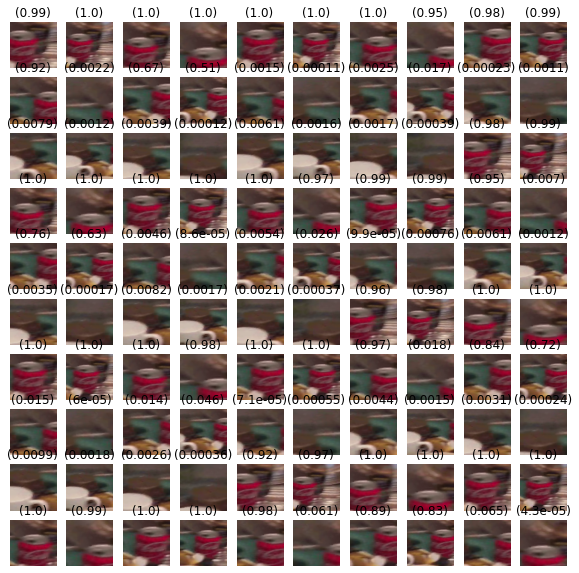

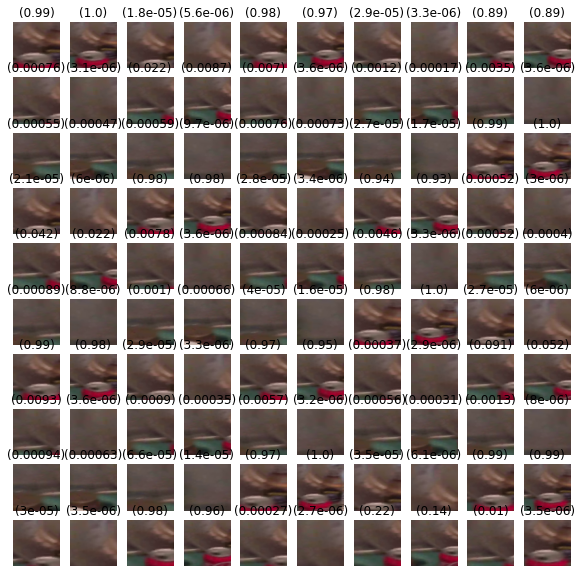

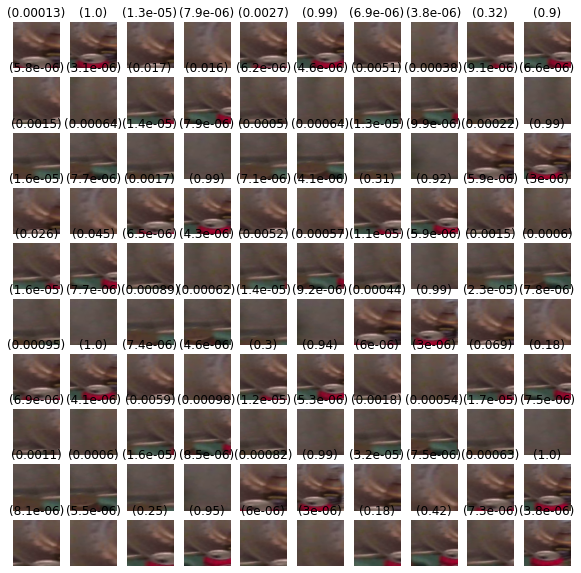

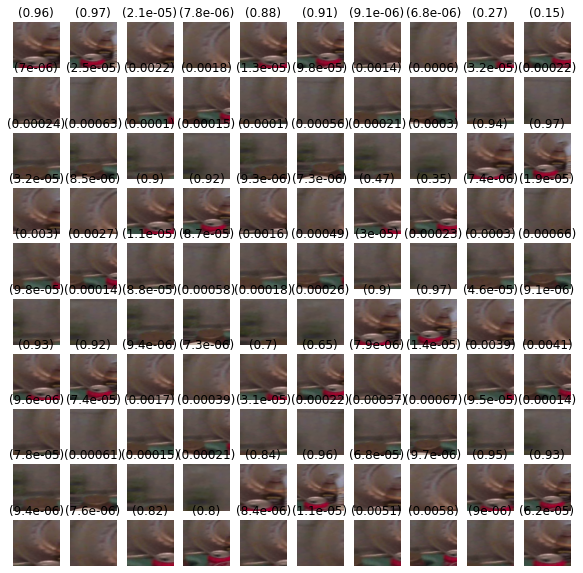

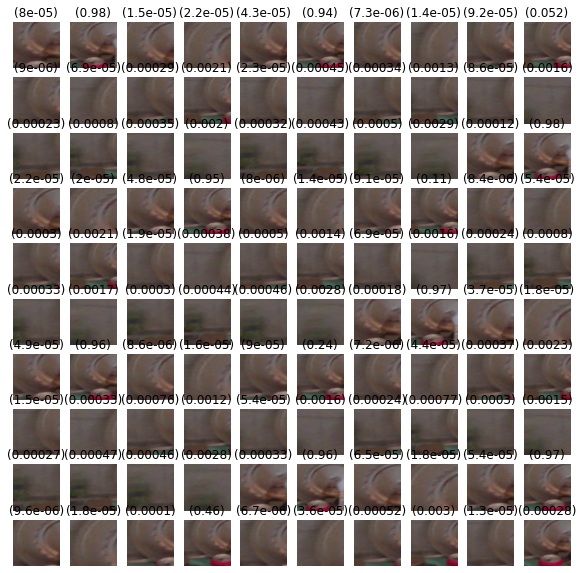

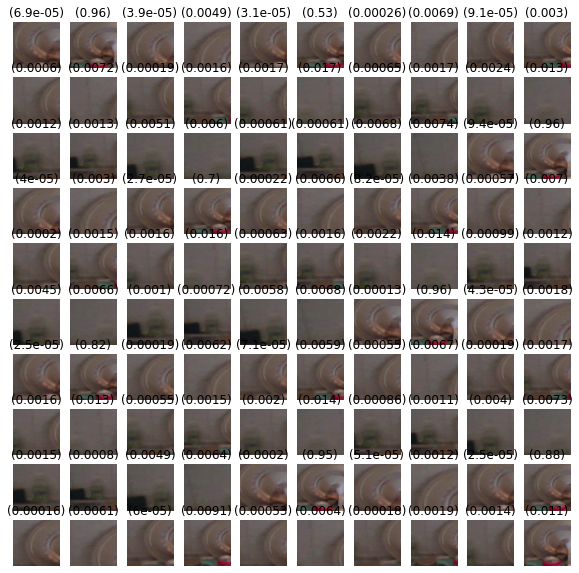

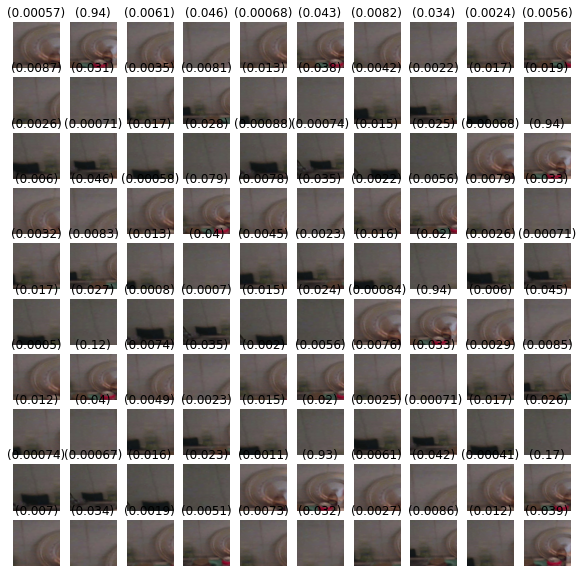

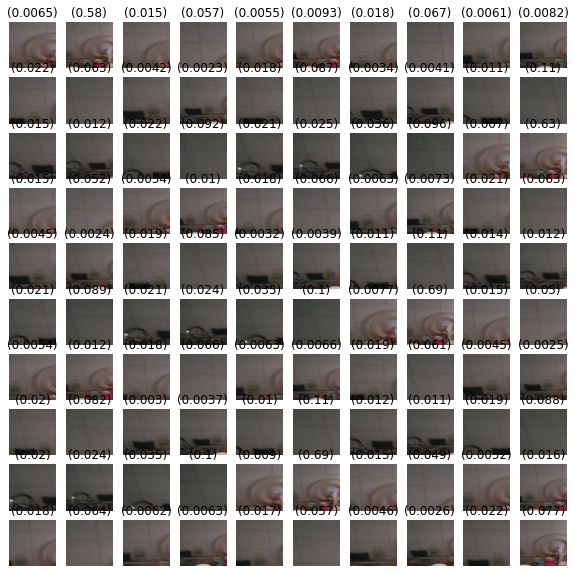

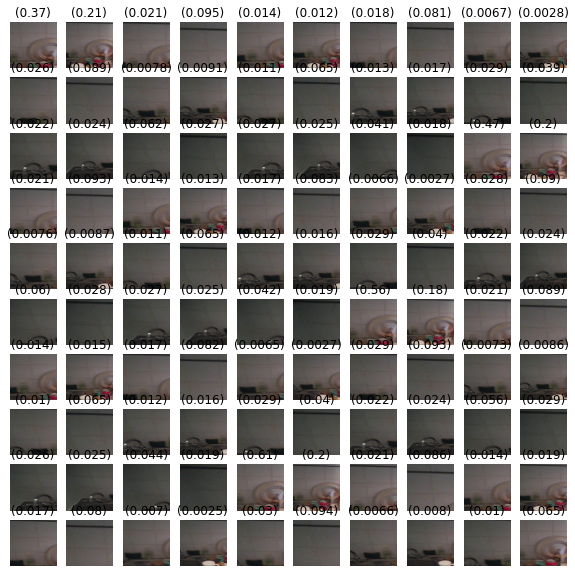

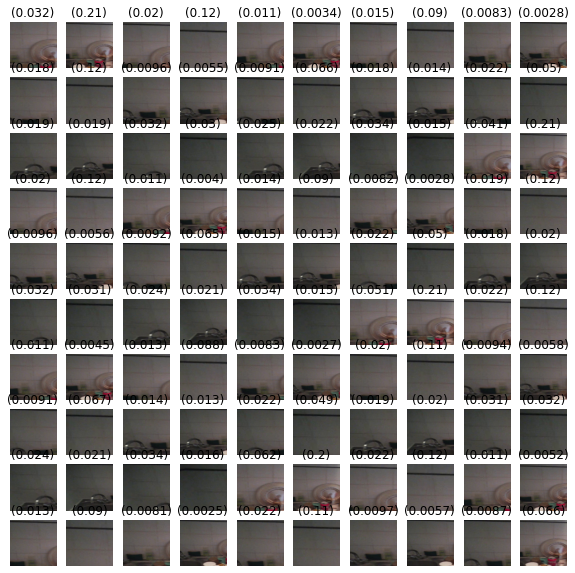

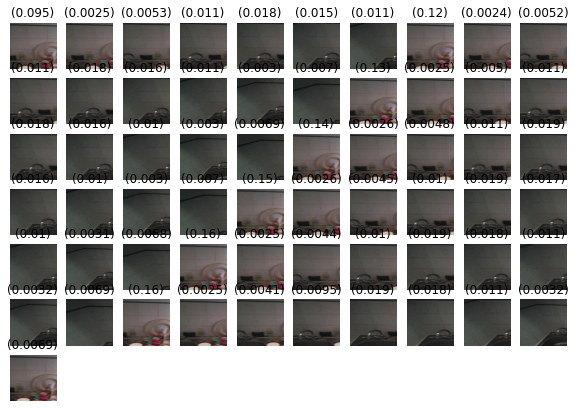

In [187]:
tracking = get_images('../VIDEOS/CanOfCocaColaPlace6Subject4.mp4')

{25: (830, 410, 78, 126),
 26: (825, 405, 78, 126),
 27: (820, 400, 78, 126),
 28: (793, 385, 93, 151),
 29: (788, 380, 93, 151),
 30: (783, 375, 93, 151),
 31: (778, 370, 93, 151),
 32: (773, 365, 93, 151),
 33: (768, 360, 93, 151),
 34: (763, 355, 93, 151),
 35: (758, 350, 93, 151),
 36: (753, 345, 93, 151),
 37: (748, 340, 93, 151),
 38: (743, 335, 93, 151),
 39: (738, 330, 93, 151),
 40: (733, 325, 93, 151),
 41: (728, 320, 93, 151),
 42: (723, 315, 93, 151),
 43: (718, 310, 93, 151),
 44: (713, 305, 93, 151),
 45: (708, 300, 93, 151),
 46: (703, 295, 93, 151),
 47: (698, 290, 93, 151),
 48: (693, 285, 93, 151),
 49: (688, 280, 93, 151),
 50: (683, 275, 93, 151),
 51: (678, 270, 93, 151),
 52: (673, 265, 93, 151),
 53: (668, 260, 93, 151),
 54: (663, 255, 93, 151),
 55: (658, 250, 93, 151),
 56: (653, 245, 93, 151),
 57: (648, 240, 93, 151),
 58: (643, 235, 93, 151),
 59: (638, 230, 93, 151),
 60: (633, 225, 93, 151),
 61: (628, 220, 93, 151),
 62: (623, 215, 93, 151),
 63: (618, 2

In [164]:
N = 1
list(range(-N, N+1, 1))

[-1, 0, 1]